#Limsa
_Locally-interacting Markov models for HIV, TB, DM in South Africa_

TODO: Initializing the model will be a challenge, becasue there is interaction between the chains for initiail placement (ie, more HIV+ people will have TB than HIV-). In order to do this, I propose using a large table to capture all the probabilites of initiailizing in different states, stratified by other states people are in, using a tagging system I'm thinking that a structure like this would be best:
* initialization_probabilities table, with these columns
    - ID
    - State_id (that person will end up in ie, TB+)
    - Tags (ie, HIV+)
    - Probability of initiailizing to this states
* tags table
    - id
    - tag name
* states table
* states-tags association table (ie, join table)

This will allow a person to initalize a model by looking at that model (ie, TB disease), seeing whether tags are required. If they are, the person finds their tags (ie, HIV-, man, urban) and finds the matching initialization probabilities. 

This is an IPython/Jupyter notebook. It is a method for creating reproducable
research. Essentially, it is a way to show "literate programming", or very well-
documented code for scientific processes. It mixes normal text with code blocks
that can be run and re-run independently.

The purpose of this IPython notebook is to organize the data that will be used
to creat the Limsa model in Go. Normally, I would complete this "pre-processing"
task in Excel, but I want to try something more detailed and reproducible.

This notebook is connected to a python application and database that will store
all the tables for the Limsa model. As we progress, we will build these tables.
*All changes to the database should be made through this notebook, so a record
of all changes is available.*

The database has tables:
* Chains
* States
* Transition probabilities
* Interactions
* References
* Raw inputs

To view the results of the tables, visit: http://limsa.org/admin

The Go model will then use these tables to run the model.

In [739]:
from IPython.display import Image
#connect to application
from app import * 
#this gives us access to the database through a variables "db"
def save(thing):
    if thing == None:
        raise ValueError('Nothing to save')
    else:
        db.session.add(thing)
        db.session.commit()
    
# remove any past problematic sessions
db.session.rollback()

# create all tables
db.drop_all()
db.create_all()
    
# drop any chains in db
db.session.query(Chain).delete()
db.session.commit()
    
# drop any states in db
db.session.query(State).delete()
db.session.commit()

# drop any raw inputs in db
db.session.query(Raw_input).delete()
db.session.commit()

# drop any references in db
db.session.query(Reference).delete()
db.session.commit()


def link_tps_to_chains():
    tps = Transition_probability.query.all()
    for tp in tps:
        from_state = tp.From_state
        chain = from_state.Chain
        tp.Chain = chain
        save(tp)
        
def visualize_chain(chain):
    tps = Transition_probability.query.filter_by(Chain=chain).all()
    G=pgv.AGraph(directed=True, rankdir="LR")
    
    for tp in tps:
        G.add_node(tp.From_state.name, shape="box", fontname="ArialMT")
        G.add_node(tp.To_state.name, shape="box", fontname="ArialMT")
        if tp.Is_dynamic:
            G.add_edge(tp.From_state.name, tp.To_state.name, label="Dynamic", fontname="ArialMT", fontsize="10") # adds edge 'b'-'c' (and also nodes 'b', 'c')
        else:
            G.add_edge(tp.From_state.name, tp.To_state.name, label=tp.Tp_base, fontname="ArialMT", fontsize="10") # adds edge 'b'-'c' (and also nodes 'b', 'c')
    G.layout(prog='dot')
    G.draw('file.png')

First, let's create the different chains the model will need.

In [740]:
# create the chains we need
chain_names = ['TB disease', 'TB treatment', 'TB resistance',
          'HIV disease', 'HIV treatment', 'HIV risk groups',
          'Setting', 'Diabetes disease', 'Diabetes treatment']
for chain_name in chain_names:
    the_chain = Chain(name=chain_name)
    save(the_chain)
    
# print chains from database
Chain.query.all()

[TB disease,
 TB treatment,
 TB resistance,
 HIV disease,
 HIV treatment,
 HIV risk groups,
 Setting,
 Diabetes disease,
 Diabetes treatment]

#TB Disease

Great. Now let's work on the TB disease chain.

###States

First, let's define the different TB states. Here is our state-transition
diagram:

![](static/imgs/tb.jpg)

In [741]:
# get TB chain
tb_chain = Chain.query.filter_by(name="TB disease").first()

# create the chains we need
state_names = ['Uninfected', 'Fast latent', 
                'Slow latent', 'Non-infectious active', 
                'Infectious active', 'Self cure from non-infectious', 
               'Self cure from infectious','Death']
for state_name in state_names:
    the_state = State(name=state_name,chain=tb_chain)
    save(the_state)
    
# print chains from database
State.query.filter_by(chain=tb_chain).all()

[Uninfected,
 Fast latent,
 Slow latent,
 Non-infectious active,
 Infectious active,
 Self cure from non-infectious,
 Self cure from infectious,
 Death]

###Gathering raw inputs

The transition from ``uninfected`` to any of the infected states is a function
of how many people are infected with TB. This will be calculated dynamically,
based on the estimated number of contacts and infectivity of contacts. In order
to be able to use this data in the Go model, I've created a table called
`Raw_inputs`. Let's save this information there. Each Raw_inputs row has a
`value`, which represents its base value, as well as a verbose `name`, a `high`
and `low`. In addition, there is a `slug`. This is a shortened version of the
name, and it will be imported and accessable from the Go code. This is
accomplished by begining the project setup with a Makefile (or setup.py) that
writes a Go file importing these variables as slugs. Yes - the python program
will *write* a Go program.

It has been shown that people with infectious TB can infect 10-15 people through
close contact per year. This can be used to calculate our base case
transmissability coefficient, although calibration will be needed.

In [742]:
# Let's use the mean as the value

low = 10.0
high = 15.0
value = (low+high)/2.0

# First save reference
bibtex = '''
@article{sanchez1997uncertainty,
  title={Uncertainty and sensitivity analysis of the basic reproductive rate: tuberculosis as an example},
  author={Sanchez, Melissa A and Blower, Sally M},
  journal={American Journal of Epidemiology},
  volume={145},
  number={12},
  pages={1127--1137},
  year={1997},
  publisher={Oxford Univ Press}
}
'''

reference = Reference(name="Sanchez 1997",bibtex=bibtex)
save(reference)

# Save input
number_of_infections_per_infected = Raw_input(
    name="Number of TB infections per TB infected",
    slug="number_of_infections_per_infected",
    value=value,
    low=low,
    high=high,
    reference=reference
)
save(number_of_infections_per_infected)

We should also create a variable that represents a transmissability coefficient
to adjust during calibration

In [743]:
trans_coeff = Raw_input(name="TB transmissability coefficient")
save(trans_coeff)

We will also need a variable to represent the % of individuals that become slow
vs fast latent.

In [744]:
## The majority develop slow latent
name = '''
Dye cite Sutherland 1968, 1976 Ferebee 1970, Comstock 1982, Sutherland et al 1982, 
Styblo 1986, Krishnamurthy et al 1976, Krishnamurthy & Chaudhuri 1990, Vynnycky 1996,
Vynnycky & Fine 1997, this study
'''

reference = Reference(name=name)
save(reference)

prop_slow = Raw_input(
    name="Proportion of individuals developing slow latent TB",
    slug="prop_slow",
    value = 0.86,
    low = 0.75,
    high = 0.92,
    reference=reference
)
save(prop_slow)


# Some develop fast latent (ie, progressive disease)
# TODO this may just be calculated as 1-slow 
prop_fast = Raw_input(
    name="Proportion of individuals developing fast latent TB",
    slug="prop_fast",
    value = 0.14,
    low = 0.08,
    high = 0.25,
    reference=reference
)
save(prop_fast)

Next, we save the rate at which slow latent develop active disease, as an annual
figure:

In [745]:
reference=Reference(name="Dye cite Horwitz et al 1969, Barnett et al 1971, Sutherland et al 1982, Styblo 1991, Vynnycky 1996, Vynnycky & Fine 1997, this study")

rate_slow_annual = Raw_input(
    name="Annual rate at slow latent develop active disease",
    slug="rate_slow_annual",
    value=0.00013,
    low=0.00010,
    high=0.00030,
    reference=reference)

save(rate_slow_annual)

Similarly, we have a rate at which fast latent develop active disease

In [746]:
reference=Reference(name="Basu cites: [5, 6, 18]")

rate_fast_annual = Raw_input(
    name="Annual rate at fast latent develop active disease",
    slug="rate_fast_annual",
    value=0.88,
	low=0.76,
    high=0.99,
    reference=reference)

save(rate_fast_annual)

It is also estimated that 65% of cases are infectious

In [747]:
reference=Reference(name="Dye cites: Styblo 1977, Murray et al 1993, Barnett & Styblo 1991")

prop_infectious = Raw_input(
    name="Proportion of active cases that are infectious",
    slug="prop_infectious",
    value=0.65,
    low=0.50,
    high=0.65,
    reference=reference
)

save(prop_infectious)

This is also a rate of self-cure.

In [748]:
reference=Reference(name="Dye cites: Springett 1971, Olakowski 1973, NTI 1974, Enarson & Rouillon 1994, Grzybowski & Enarson 1978")

rate_self_cure_annual = Raw_input(
    name="Annual rate of self-cure",
    slug="rate_self_cure_annual",
    value=0.020,
    low=0.15,
    high=0.25,
    reference=reference
)

save(rate_self_cure_annual)

And an ability to replase from self cure

In [749]:
reference=Reference(name="Dye cites: Springett 1961, Grzybowski et al 1965, Ferebee 1970, Chan-Yeung et al 1971, Campbell 1974, Nakielna et al 1975, Styblo 1986")

rate_relapse_from_self_cure_annual = Raw_input(
    name="Annual rate of relapse from self-cure",
    slug="rate_relapse_from_self_cure_annual",
    value=0.03,
    low=0.02,
    high=0.04,
    reference=reference
)

save(rate_relapse_from_self_cure_annual)

Individuals can also convert from non-infectious to infection at a specified
rate

In [750]:
reference = Reference(name="Dye cites Ferebee 1970, HKCS 1974")

rate_conversion_annual = Raw_input(
    name="Annual rate of conversion from non-infectious to infectious",
    slug="rate_conversion_annual",
    value = 0.015,
    low =0.007,
    high = 0.02,
    reference=reference)

save(rate_conversion_annual)

####Mortality

Individuals can die of infectious active TB as well as non-infectious active TB.

In [751]:
#### infectious TB
reference = Reference(name="Dye who cites Rutledge & Crouch 1919, Berg 1939, Drolet 1938, Thompson 1943, Tatersall 1947, Lowe 1954, Springett 1971, NTI 1974, Grzybowski & Enarson 1978")

infect_tb_mort_annual = Raw_input(
    name="Yearly mortality from infectious TB",
    slug="infect_tb_mort_annual",
    value=0.30,
    low=0.20,
    high=0.40,
    reference=reference
)
save(infect_tb_mort_annual)

reference = Reference(name="Dye who cites Lindhart 1939, Murray et al 1993")

noninfect_tb_mort_annual = Raw_input(
    name="Yearly mortality from non-infectious TB",
    slug="noninfect_tb_mort_annual",
    value=0.21,
    low=0.18,
    high=0.25,
    reference=reference
)

save(noninfect_tb_mort_annual)

### Transition probabilities

Now, we can fill in the basic transition probabilties for this chain.

In [752]:
# For later visualizaton scripts
import pygraphviz as pgv
import time


# In order to convert yearly rates to quarterly rates, we use the following function
# TODO this is not really true - to discuss
def convert_year_to_qt(value):
    return value/4


# TODO: Run PSA changes here?

# TODO: should there be a function that fills in recursive TPs?

# get all states of the TB disease chain
uninfected_state=State.query.filter_by(name="Uninfected",chain=tb_chain).first()
fast_latent_state=State.query.filter_by(name="Fast latent",chain=tb_chain).first()
slow_latent_state=State.query.filter_by(name="Slow latent", chain=tb_chain).first()
noninfectious_active_state=State.query.filter_by(name="Non-infectious active", chain=tb_chain).first()
infectious_active_state=State.query.filter_by(name="Infectious active", chain=tb_chain).first()
self_cure_from_noninfectious = State.query.filter_by(name="Self cure from non-infectious", chain=tb_chain).first()
self_cure_from_infectious = State.query.filter_by(name="Self cure from infectious", chain=tb_chain).first()
death_state=State.query.filter_by(name="Death", chain=tb_chain).first()

#Infection to fast latent
save(Transition_probability(
    From_state=uninfected_state,
    To_state=fast_latent_state,
    Is_dynamic=True
))




# Infection to slow latent
save(Transition_probability(
    From_state=uninfected_state,
    To_state=slow_latent_state,
    Is_dynamic=True
))

# Slow latent to non-infectious active

slow_to_noninfectious_active = convert_year_to_qt(rate_slow_annual.value*(1.0-prop_infectious.value))

save(Transition_probability(
    From_state=slow_latent_state,
    To_state=noninfectious_active_state,
    Tp_base=slow_to_noninfectious_active
))

# Slow latent to infectious active

slow_to_infectious_active = convert_year_to_qt(rate_slow_annual.value*prop_infectious.value)

save(Transition_probability(
    From_state=slow_latent_state,
    To_state=infectious_active_state,
    Tp_base=slow_to_infectious_active
))

# Fast latent to non-infectious active

fast_to_noninfectious_active = convert_year_to_qt(rate_fast_annual.value*(1.0-prop_infectious.value))

save(Transition_probability(
    From_state=fast_latent_state,
    To_state=noninfectious_active_state,
    Tp_base=fast_to_noninfectious_active
))

# Fast latent to infectious active

fast_to_infectious_active = convert_year_to_qt(rate_fast_annual.value*prop_infectious.value)

save(Transition_probability(
    From_state=fast_latent_state,
    To_state=infectious_active_state,
    Tp_base=fast_to_infectious_active
))

# Self cure - infectious

rate_self_cure_qt = convert_year_to_qt(rate_self_cure_annual.value)

save(Transition_probability(
    From_state=infectious_active_state,
    To_state=self_cure_from_infectious,
    Tp_base=rate_self_cure_qt
))

# Self cure - noninfectious

rate_self_cure_qt = convert_year_to_qt(rate_self_cure_annual.value)

save(Transition_probability(
    From_state=noninfectious_active_state,
    To_state=self_cure_from_noninfectious,
    Tp_base=rate_self_cure_qt
))

# Relapse from self cure - infectious

rate_relapse_from_self_cure_qt = convert_year_to_qt(rate_relapse_from_self_cure_annual.value)

save(Transition_probability(
    From_state=self_cure_from_infectious ,
    To_state=infectious_active_state,
    Tp_base=rate_relapse_from_self_cure_qt
))

# Replase from self cure - noninfectious

rate_relapse_from_self_cure_qt = convert_year_to_qt(rate_relapse_from_self_cure_annual.value)

save(Transition_probability(
    From_state=self_cure_from_noninfectious,
    To_state=noninfectious_active_state,
    Tp_base=rate_relapse_from_self_cure_qt
))


# Conversion from non-infectious to infectious

rate_conversion_qt = convert_year_to_qt(rate_conversion_annual.value)

save(Transition_probability(
    From_state=noninfectious_active_state,
    To_state=infectious_active_state,
    Tp_base=rate_conversion_qt
))


# Mortality - from noninfectious

noninfect_tb_mort_qt = convert_year_to_qt(noninfect_tb_mort_annual.value)

save(Transition_probability(
    From_state=noninfectious_active_state,
    To_state=death_state,
    Tp_base=noninfect_tb_mort_qt
))

# Mortality - from infectious

infect_tb_mort_qt = convert_year_to_qt(infect_tb_mort_annual.value)

save(Transition_probability(
    From_state=infectious_active_state,
    To_state=death_state,
    Tp_base=infect_tb_mort_qt
))

Now that we've completed building the transitions matrix, we can visualize all
the transitions (recursive transitions not shown).

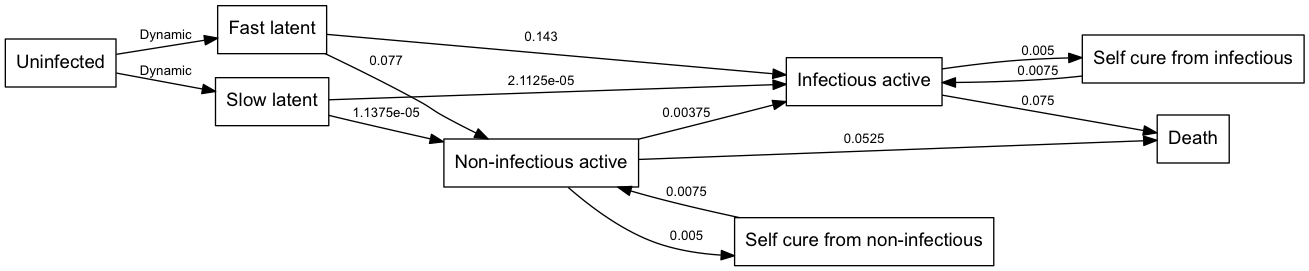

In [753]:
link_tps_to_chains()
visualize_chain(tb_chain)
Image(filename='file.png')

#TB resistance

Next, let's move on to discuss TB resistance. We want to model an uninfected
state, as well as five different diseased states:

* Fully Susceptible
* INH-monoresistant
* RIF-monoresistant
* MDR
* XDR

Let's get the chain for resistance, and add these states to the chain.

In [754]:
# get TB resistance chain
tb_resistance_chain = Chain.query.filter_by(name="TB resistance").first()

# create the chains we need
state_names = ["Uninfected","Fully Susceptible","INH-monoresistant",
               "RIF-monoresistant","MDR","XDR", "Death"]

# save them with TB resistance chain
for state_name in state_names:
    the_state = State(name=state_name,chain=tb_resistance_chain)
    save(the_state)
    
# print chains from database
State.query.filter_by(chain=tb_resistance_chain).all()

[Uninfected,
 Fully Susceptible,
 INH-monoresistant,
 RIF-monoresistant,
 MDR,
 XDR,
 Death]

##Gathering raw inputs

The transition probabilities for aquiring a resistant infection are the sum of:
* the chance of your current strain becoming endogenously resistant
* the chance you will become infected with a drug-resistant strain from someone
else

The later will need to be calculated dynamically, but we can store the former as
raw input to be used by the model. Let's do that.

In [755]:
reference = Reference(name="Basu calibration")

# DS -> INHR

endo_rate_ds_to_inhr_annual = Raw_input(
    name="Annual rate of endogenous conversion from drug-suseptible to INH resistant",
    slug="endo_rate_ds_to_inhr_annual",
    value=0.038,
    low=0.025,
    high=0.050,
    reference=reference
)

save(endo_rate_ds_to_inhr_annual)

# DS -> RIFR

endo_rate_ds_to_rifr_annual = Raw_input(
    name="Annual rate of endogenous conversion from drug-suseptible to RIF resistant",
    slug="endo_rate_ds_to_rifr_annual",
    value=0.038,
    low=0.025,
    high=0.050,
    reference=reference 
)

save(endo_rate_ds_to_rifr_annual)

# RIFR -> MDR

endo_rate_rifr_to_mdr_annual = Raw_input(
    name="Annual rate of endogenous conversion from RFI resistant to MD resistant",
    slug="endo_rate_rifr_to_mdr_annual",
    value=0.038,
    low=0.025,
    high=0.050,
    reference=reference 
)

save(endo_rate_rifr_to_mdr_annual)

# INHR -> MDR

endo_rate_inhr_to_mdr_annual = Raw_input(
	 name="Annual rate of endogenous conversion from INHR to MD resistant",
    slug="endo_rate_inhr_to_mdr_annual",
    value=0.038,
	 low=0.025,
	 high=0.050,
	 reference=reference 
)

save(endo_rate_inhr_to_mdr_annual)

# MDR->XDR

endo_rate_mdr_to_xdr_annual = Raw_input(
    name="Annual rate of endogenous conversion from MDR to XD resistant",
    slug="endo_rate_mdr_to_xdr_annual",
    value=0.030,
    low=0.025,
    high=0.050,
    reference=reference 
)

save(endo_rate_mdr_to_xdr_annual)

## Transition probabilities

As mentioned above, these will need to be calcualted dynamically. Let's add them
in, but mark them all as dynamic.

In [756]:
# get TB resistance chain
tb_resistance_chain = Chain.query.filter_by(name="TB resistance").first()

# Get states
uninfected_state=State.query.filter_by(name="Uninfected",chain=tb_resistance_chain).first()
fully_susceptible_state=State.query.filter_by(name="Fully Susceptible",chain=tb_resistance_chain).first()
inh_monoresistant_state=State.query.filter_by(name="INH-monoresistant", chain=tb_resistance_chain).first()
rif_monoresistant_state=State.query.filter_by(name="RIF-monoresistant", chain=tb_resistance_chain).first()
mdr_state=State.query.filter_by(name="MDR", chain=tb_resistance_chain).first()
xdr_state=State.query.filter_by(name="XDR", chain=tb_resistance_chain).first()

# Uninfected to infected
save(Transition_probability(
    From_state=uninfected_state,
    To_state=fully_susceptible_state,
    Is_dynamic=True
))

# DS to RIF
save(Transition_probability(
    From_state=fully_susceptible_state,
    To_state=rif_monoresistant_state,
    Is_dynamic=True
))

# DS to INHR
save(Transition_probability(
    From_state=fully_susceptible_state,
    To_state=inh_monoresistant_state,
    Is_dynamic=True
))

#  RIF to MDR
save(Transition_probability(
    From_state=rif_monoresistant_state,
    To_state=mdr_state,
    Is_dynamic=True
))

# IHN to MDR
save(Transition_probability(
    From_state=inh_monoresistant_state,
    To_state=mdr_state,
    Is_dynamic=True
))

# MDR to XDR
save(Transition_probability(
    From_state=mdr_state,
    To_state=xdr_state,
    Is_dynamic=True
))

We can now visualize this chain.

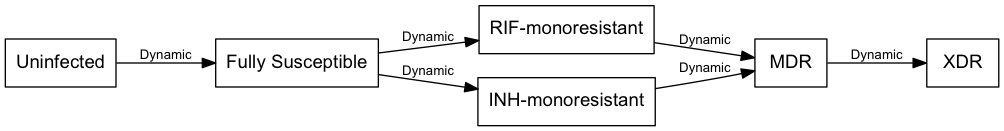

In [757]:
link_tps_to_chains()
visualize_chain(tb_resistance_chain)
Image(filename='file.png')

#TB treatment

Now, let's turn our attention to the TB treatment model. In addition to the
uninfected state, we need to model three diseased states: untreated (latent),
untreated (active) and treated. Let's create those states.

In [758]:
# get TB treatment chain
tb_treatment_chain = Chain.query.filter_by(name="TB treatment").first()

# create the chains we need
state_names = ["Uninfected","Untreated - Latent", "Untreated - Active", "Treated", "Death"]

# save them with TB resistance chain
for state_name in state_names:
    the_state = State(name=state_name,chain=tb_treatment_chain)
    save(the_state)
    
# print chains from database
State.query.filter_by(chain=tb_treatment_chain).all()

[Uninfected, Untreated - Latent, Untreated - Active, Treated, Death]

##Raw inputs

Now let's look at the raw data.

Obviously, transition from uninfected to untreated latent and untreated latent
to untreated active are dynamic.

Treatment uptake rates for active infections are not readily available. However,
there is an estimated case detection of 62% (52–75).1

In [759]:
reference = Reference(name="WHO. Global tuberculosis report 2013. (2013)")

case_detection_rate = Raw_input(
    name="Estimated case detection",
    slug="case_detection_rate",
    value=0.62,
    low=0.52,
    high=0.75,
    reference=reference
)

save(case_detection_rate)

One study of 376 confirmed active cases in South Africa suggested that only 74%
of those diagnosed started treatment. I will assume that the high and low are
0.7 and 0.8

In [760]:
reference = Reference(name="Botha, E. et al. From suspect to patient...")

percent_diagnosed_treated = Raw_input(
    name="Proportion of diagnosed that recieve treatment",
    slug="percent_diagnosed_treated",
    value=0.74,
    low=0.7,
    high=0.8,
    reference=reference
)

save(percent_diagnosed_treated)

Althougth this is not fully accurate, we can estimate the total percent of
individuals who recieve treatment using these two values.

In [761]:
overall_percent_active_treated = Raw_input(
    name="Percent of all active that will be treated",
    slug="overall_percent_active_treated",
    value=percent_diagnosed_treated.value * case_detection_rate.value,
    low=percent_diagnosed_treated.low * case_detection_rate.low,
    high=percent_diagnosed_treated.high * case_detection_rate.high,
)

save(overall_percent_active_treated)

We will also assume that there is a drop-out rate of 10% (5-15%)

In [762]:
drop_out_rate_annual = Raw_input(
    name="Annual drop out rate",
    slug="drop_out_rate_annual",
    value=0.1,
    low=0.05,
    high=0.15
)

save(drop_out_rate_annual)

##Transition probabilities

Now let's add in the transition probabilities.

In [763]:
# convert annual to quarterly 

drop_out_rate_qt = convert_year_to_qt(drop_out_rate_annual.value)
enrollment_rate_qt = convert_year_to_qt(overall_percent_active_treated.value)


# get TB resistance chain
tb_treatment_chain = Chain.query.filter_by(name="TB treatment").first()

# Get states
uninfected_state=State.query.filter_by(name="Uninfected",chain=tb_treatment_chain).first()
untreated_latent_state=State.query.filter_by(name="Untreated - Latent",chain=tb_treatment_chain).first()
untreated_active_state=State.query.filter_by(name="Untreated - Active", chain=tb_treatment_chain).first()
treated_state=State.query.filter_by(name="Treated", chain=tb_treatment_chain).first()


# Uninfected to untreated latent
save(Transition_probability(
    From_state=uninfected_state,
    To_state=untreated_latent_state,
    Is_dynamic=True
))

# Untreated latent to untreated active
save(Transition_probability(
    From_state=untreated_latent_state,
    To_state=untreated_active_state,
    Is_dynamic=True
))


# Enrollment - Untreated active to treated active
save(Transition_probability(
    From_state=untreated_active_state,
    To_state=treated_state,
    Tp_base=enrollment_rate_qt
))


# Drop - out Untreated active to untreated active
save(Transition_probability(
    From_state=treated_state,
    To_state=untreated_active_state,
     Tp_base=drop_out_rate_qt
))

Now, let's visualize this chain.

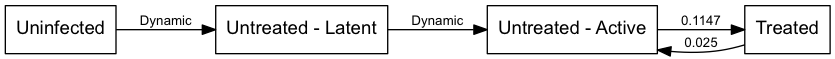

In [764]:
link_tps_to_chains()
visualize_chain(tb_treatment_chain)
Image(filename='file.png')

#HIV disease

Now, lets turn our attention to the HIV model. Let's start by building the
disease model. Let's first build the states.

In [765]:

# get TB resistance chain
hiv_disease_chain = Chain.query.filter_by(name="HIV disease").first()

# create the chains we need
state_names = ["Uninfected", "Acute", "Early",
    "Late", "Advanced/AIDS", "Death" ]

# save them with TB resistance chain
for state_name in state_names:
    the_state = State(name=state_name,chain=hiv_disease_chain)
    save(the_state)
    
# print chains from database

Because the transition probabilites for infection are dynamic, we need to build some raw inputs.

Firstly, let's look at condom effectiveness. Let's assume a 0.9 to 1 low and
high

In [766]:

reference = Reference(name="Alistar, S. S., Grant, P. M. & Bendavid, E. Comparative effectiveness and cost-effectiveness of antiretroviral therapy and pre-exposure prophylaxis for HIV prevention in South Africa. BMC Med. 12, 46 (2014).")

condom_effectiveness = Raw_input(
    name="Condom effectiveness",
    slug="condom_effectiveness",
    value=0.95,
    low=0.9,
    high=1,
    reference=reference
)

save(condom_effectiveness)

Next, we can look at condom use.

In [767]:

reference = Reference(name="http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2654146/pdf/U9G-85-S1-0072.pdf, 2007")

condom_use = Raw_input(
    name="Proportion of times people use condoms",
    slug="condom_use",
    value=0.25,
    low=0.1,
    high=0.4,
    reference=reference
)

save(condom_use)

And now many partnerships people have in general. We will assume the high and low of 1 and 2.

In [768]:

reference = Reference(name="http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2654146/pdf/U9G-85-S1-0072.pdf, 2007")

general_parternships = Raw_input(
    name="Number of partnerships",
    slug="general_parternships",
    value=1.19,
    low=1,
    high=2,
    reference=reference
)


Now let's look at the transmission likelyhood per partnership. Note: the sources provide a high and low; I've just taken the mean as our best estimate.

In [769]:

reference = Reference(name="Alistar 137 using data from Cohen 33 and Hollingsworth 138")

trans_per_partnership = Raw_input(
    name="Transmission likelyhood per partnership",
    slug="trans_per_partnership",
    value=0.077,
    low=0.004,
    high=0.15,
    reference=reference
)

save(trans_per_partnership)

We also need information about the sexual behavior of the different risk populations.

###Sex workers

The condom use of sex workers.

In [770]:

reference = Reference(name="As cited in 139 Billinghurst, K. 1999. Chief Medical Officer,...")

condom_use_sex_workers = Raw_input(
    name="Condom use sex workers (proportion)",
    slug="condom_use_sex_workers",
    value=0.902,
    low=0.50,
    high=0.902,
    reference=reference
)
    
save(condom_use_sex_workers)


And the number of partners per year.

In [771]:

reference = Reference(name="Billinghurst, K. (1999). Chief Medical Officer, CDCHIV AIDS STD Program Mpumalanga Department of Health, Unpublished project data.")

csw_number_of_partners_per_year = Raw_input(
    name="CSW number of partners per year",
    slug="csw_number_of_partners_per_year",
    value=25,
    low=10,
    high=100,
)

save(csw_number_of_partners_per_year)


And the number of episodes per client.

In [772]:

reference = Reference(name="Marseille, E., Kahn, J. G., Billinghurst, K. & Saba, J. Cost-effectiveness of...")

csw_episodes_per_client = Raw_input(
    name="Number of episodes per client",
    slug="csw_episodes_per_client",
    value=2,
    low=1,
    high=5,
)

save(csw_episodes_per_client)

And the proportion of men who use the services

In [773]:

reference = Reference(name="From surrounding countries, http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2576731/")

prop_mem_use_services = Raw_input(
    name="Proportion of men who use CSW services",
    slug="prop_mem_use_services",
    value=0.015,
    low=0.02,
    high=0.03,
    reference=reference
)

save(prop_mem_use_services)


###Men who have sex with men

The number of annual partnership for MSM - High and low are WAG

In [774]:

reference = Reference(name="Extraction notes unclear")

num_partners_msm = Raw_input(
    name="The number of annual partnership for MSM",
    slug="num_partners_msm",
    value=4.6,
    low=1,
    high=10,
    reference=reference
)

save(num_partners_msm)
    


Next, we to look at the average condom use for MSM. High and low are WAG.

In [775]:

reference = Reference(name="2011** limited survey area - % reported always using condoms with male sexual partner, HIV Risk and Associations of HIV Infection among MSM in peri-urban Cape Town, South Africa")

condom_use_msm = Raw_input(
    name="average condom use for MSM",
    slug="condom_use_msm",
    value=0.524,
    low=0.4,
    high=0.6,
    reference=reference
)

save(condom_use_msm)


###IDUs

We also must look at IDUs. We assume that they use condoms 20% (10-30%) of the time.

In [776]:

reference = Reference(name="Assumed")

condom_use_idus = Raw_input(
    name="IDU condom use",
    slug="condom_use_idus",
    value=0.2,
    low=0.1,
    high=0.3,
    reference=reference
)

save(condom_use_idus)


Can also estimate the total number of injections per year per IDUs. High and low are WAGs.

In [777]:
reference = Reference(name="Assumed from Russian data. Notes from extractor: <30 : 64%, >= 30: 36, Potential for 2009 Bridging of HIV Transmission in the Russian Federation, http://www.springerlink.com/content/k24j760325026677/fulltext.pdf")

num_injections_idu_annual = Raw_input(
    name="total number of injections per year per IDUs",
    slug="num_injections_idu_annual",
    value=264,
    low=200,
    high=300,
    reference=reference
)

save(num_injections_idu_annual)

We must also estimate their annual partnerships. High and low are WAGs.

In [778]:

reference = Reference(name="Assumed from Tanzanian data. Notes from extractor: Reid, Savanna R. Injection Drug Use, Unsafe Medical Injections, and HIV in Africa: A Systematic Review. HRJ. ., n.d. Web. 25 Feb. 2013.")

partnerships_idus = Raw_input(
    name="Annual partnerships, IDUs",
    slug="partnerships_idus",
    value=2.4,
    low=2,
    high=3,
    reference=reference
)

save(partnerships_idus)



We must also estimate the proportion of IDUs that are male

In [779]:

reference = Reference(name="Assumed")

prop_male_idus = Raw_input(
    name="proportion of IDUs that are male",
    slug="prop_male_idus",
    value=0.80,
    low=0.80,
    high=0.80,
    reference=reference
)

save(prop_male_idus)
    

###Disease progression

TODO: This annual transition will not work because transfer from acute happens very quickly (6mo).

In [780]:

reference = Reference(name="Allistar")

acute_to_early_annual = Raw_input(
    name="Annual proportion of acute that transfer to early",
    slug="acute_to_early_annual",
    value=1,
    low=1,
    high=1,
    reference=reference
)

save(acute_to_early_annual)


Now we should look at early to late

In [781]:

# same reference as before
early_to_late_annual = Raw_input(
    name="Early to late, annual",
    slug="early_to_late_annual",
    value=0.164,
    low=0.15,
    high=0.178,
    reference=reference
)

save(early_to_late_annual)


Now we should look at late to advanced/AIDS

In [782]:

late_to_adv_annual = Raw_input(
    name="Late to advanced/AIDS",
    slug="late_to_adv_annual",
    value=0.26,
    low=0.23,
    high=0.29,
    reference=reference
)

save(late_to_adv_annual)
    

##HIV mortality

We can now look at mortality estimates from each of the different HIV states. Individuals cannot die of HIV in the acute phase.

In [783]:
#same reference as above
early_hiv_mortality_annual = Raw_input(
    name="Early HIV mortality annual",
    slug="early_hiv_mortality_annual",
    value=0.008,
    low=0.006,
    high=0.01,
    reference=reference
)

save(early_hiv_mortality_annual)

And late phase

In [784]:
#same reference as above
late_hiv_mortality_annual = Raw_input(
    name="Late HIV mortality annual",
    slug="late_hiv_mortality_annual",
    value=0.09,
    low=0.08,
    high=0.1,
    reference=reference
)

save(late_hiv_mortality_annual)

And Advanced/AIDS

In [785]:
#same reference as above
advanced_hiv_mortality_annual = Raw_input(
    name="Advanced HIV mortality annual",
    slug="advanced_hiv_mortality_annual",
    value=0.45,
    low=0.4,
    high=0.5,
    reference=reference
)

save(advanced_hiv_mortality_annual)

##Transition probabilites

We do not allow reverse transitions.

In [786]:

# get TB resistance chain
hiv_disease_chain = Chain.query.filter_by(name="HIV disease").first()

# Get states
uninfected_state=State.query.filter_by(name="Uninfected",chain=hiv_disease_chain).first()
acute_state=State.query.filter_by(name="Acute",chain=hiv_disease_chain).first()
early_state=State.query.filter_by(name="Early",chain=hiv_disease_chain).first()
late_state=State.query.filter_by(name="Late", chain=hiv_disease_chain).first()
advanced_state=State.query.filter_by(name="Advanced/AIDS", chain=hiv_disease_chain).first()
death_state=State.query.filter_by(name="Death", chain=hiv_disease_chain).first()

acute_to_early_qt = convert_year_to_qt(acute_to_early_annual.value)
early_to_late_qt = convert_year_to_qt(early_to_late_annual.value)
late_to_adv_qt = convert_year_to_qt(late_to_adv_annual.value)


### TPs in disease state

In [787]:

# Uninfected to acute
save(Transition_probability(
        From_state=uninfected_state,
        To_state=acute_state,
        Tp_base=0,
        Is_dynamic=True
    ))

#Acute to early
save(Transition_probability(
    From_state=acute_state,
    To_state=early_state,
    Tp_base=acute_to_early_qt,
    Is_dynamic=False
))

#Early to late

save(Transition_probability(
    From_state=early_state,
    To_state=late_state,
    Tp_base=early_to_late_qt,
    Is_dynamic=False
))
    
# Late to advanced

save(Transition_probability(
    From_state=late_state,
    To_state=advanced_state,
    Tp_base=late_to_adv_qt,
    Is_dynamic=False
))      


###Mortality TPs

In [788]:

early_hiv_mortality_qt = convert_year_to_qt(early_hiv_mortality_annual.value)
late_hiv_mortality_qt = convert_year_to_qt(late_hiv_mortality_annual.value)
advanced_hiv_mortality_qt = convert_year_to_qt(advanced_hiv_mortality_annual.value)


#Early to death

save(Transition_probability(
    From_state=early_state,
    To_state=death_state,
    Tp_base=early_hiv_mortality_qt,
    Is_dynamic=False
))
    
# Late to death

save(Transition_probability(
    From_state=late_state,
    To_state=death_state,
    Tp_base=late_hiv_mortality_qt,
    Is_dynamic=False
))    

# Advanced to death

save(Transition_probability(
    From_state=advanced_state,
    To_state=death_state,
    Tp_base=advanced_hiv_mortality_qt,
    Is_dynamic=False
))    

Now, we can visualize this chain:

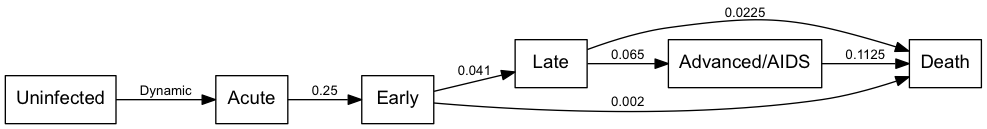

In [789]:
link_tps_to_chains()
visualize_chain(hiv_disease_chain)
Image(filename='file.png')

#HIV treatment

First, let's build the states.

In [790]:
# get TB chain
hiv_treatment_chain = Chain.query.filter_by(name="HIV treatment").first()

# create the chains we need
state_names = ['Uninfected', "Untreated", "Treated" ,'Death']
for state_name in state_names:
    the_state = State(name=state_name,chain=hiv_treatment_chain)
    save(the_state)
    
# print chains from database
State.query.filter_by(chain=hiv_treatment_chain).all()

[Uninfected, Untreated, Treated, Death]

##Raw inputs

Let's first import all the raw inputs. We can look at treatment drop out rate:

In [791]:

reference = Reference(name="Allistar")

hiv_treatment_drop_out_annual = Raw_input(
    name="HIV treatment drop out",
    slug="hiv_treatment_drop_out_annual",
    value=0.02,
    low=0,
    high=0.02,
    reference=reference
)

save(hiv_treatment_drop_out_annual)


As well as treatment recruitment. High and low are WAG.

In [792]:

#same reference as above

hiv_treatment_recruitment_annual = Raw_input(
    name="HIV treatment recruitment all states",
    slug="hiv_treatment_recruitment_annual",
    value=0.1,
    low=0.05,
    high=0.15,
    reference=reference
)

save(hiv_treatment_recruitment_annual)

##Transition probabilites

Now we can build the transition probabilities.

In [793]:
# get TB resistance chain
tb_treatment_chain = Chain.query.filter_by(name="TB treatment").first()

# convert annual to quarterly
hiv_treatment_drop_out_qt = convert_year_to_qt(hiv_treatment_drop_out_annual.value)
hiv_treatment_recruitment_qt = convert_year_to_qt(hiv_treatment_recruitment_annual.value)

# Get states
uninfected_state=State.query.filter_by(name="Uninfected",chain=hiv_treatment_chain).first()
untreated_state=State.query.filter_by(name="Untreated",chain=hiv_treatment_chain).first()
treated_state=State.query.filter_by(name="Treated", chain=hiv_treatment_chain).first()
death_state=State.query.filter_by(name="Death", chain=hiv_treatment_chain).first()

# Uninfected to untreated
save(Transition_probability(
    From_state=uninfected_state,
    To_state=untreated_state,
    Is_dynamic=True
))

# Untreated to treated
save(Transition_probability(
    From_state=untreated_state,
    To_state=treated_state,
    Tp_base=hiv_treatment_recruitment_qt,
    Is_dynamic=False
))

# Treated to untreated (ie, drop outs)
save(Transition_probability(
    From_state=treated_state,
    To_state=untreated_state,
    Tp_base=hiv_treatment_drop_out_qt,
    Is_dynamic=False
))

We can now visualize this chain.

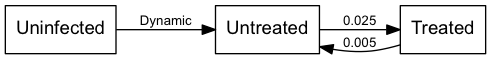

In [794]:
link_tps_to_chains()
visualize_chain(hiv_treatment_chain)
Image(filename='file.png')

#HIV risk groups

In addition to the disease chains, we need a demopgraphics chain to allow for the calculation of dynamic transition probabilities for the HIV infection transition.

In [795]:
# get TB chain
hiv_risk_groups_chain = Chain.query.filter_by(name="HIV risk groups").first()

# create the chains we need
state_names = ['General population male', 'General population female', 'Sex worker', 'IDU male', 'IDU female', 'MSM', 'Death']
for state_name in state_names:
    the_state = State(name=state_name,chain=hiv_risk_groups_chain)
    save(the_state)
    
# print chains from database
State.query.filter_by(chain=hiv_risk_groups_chain).all()

[General population male,
 General population female,
 Sex worker,
 IDU male,
 IDU female,
 MSM,
 Death]

##Raw inputs

First, let's record how many people are in each category.

In [796]:

reference = Reference(name="WDI 2011, http://data.worldbank.org/country/south-africa")

# Men

num_gen_pop_men = Raw_input(
    name="Number of general population men",
    slug="num_gen_pop_men",
    value=13351277,
    low=13351277,
    high=13351277,
    reference=reference
)

save(num_gen_pop_men)

# Women

reference = Reference(name="http://www.prb.org/pdf11/world-women-girls-2011-data-sheet.pdf, 2011")

num_gen_pop_women = Raw_input(
    name="Number of general population women",
    slug="num_gen_pop_women",
    value=13621000,
    low=13621000,
    high=13621000,
    reference=reference
)

save(num_gen_pop_women)

# IDU

reference = Reference(name="2009 http://www.harmreductionjournal.com/content/6/1/24/table/T2 table 2    IDU prevalence in 2008 was 0.15% of the population *value was extrapolated")

num_idu = Raw_input(
    name="Number of IDUs",
    slug="num_idu",
    value=13621000,
    low=13621000,
    high=13621000,
    reference=reference
)

save(num_idu)

# MSM

reference = Reference(name="2006 study of rural south african men, Factors associated with HIV sero-positivity in young, rural South African men, http://www.ncbi.nlm.nih.gov/pubmed/17030525    3.6% extrapolated to total population of men ** limited sample area")

num_msm = Raw_input(
    name="Number of MSM",
    slug="num_msm",
    value=13621000,
    low=13621000,
    high=13621000,
    reference=reference
)

save(num_msm)
    
# CSW

reference = Reference(name="Assumed, 0.2% of women")

num_csw = Raw_input(
    name="Number of CSW",
    slug="num_csw",
    value=27242,
    low=27242,
    high=27242,
    reference=reference
)

save(num_csw)


##Transition probabilites

Since data is lacking regarding the transition from one demopgraphic group to the next, many of these variabels will need to be determined through calibration. Also, many of these variables don't have "raw data" associated with them, so you will note that we're adding values directly into the transition probabilites.

In [797]:
# get TB resistance chain
hiv_risk_groups_chain = Chain.query.filter_by(name="HIV risk groups").first()

# Get states

general_population_male_state =State.query.filter_by(name="General population male", chain=hiv_risk_groups_chain).first()
general_population_female_state =State.query.filter_by(name="General population female", chain=hiv_risk_groups_chain).first()
sex_worker_state =State.query.filter_by(name="Sex worker", chain=hiv_risk_groups_chain).first()
idu_male_state =State.query.filter_by(name="IDU male", chain=hiv_risk_groups_chain).first()
idu_female_state =State.query.filter_by(name="IDU female", chain=hiv_risk_groups_chain).first()
msm_state =State.query.filter_by(name="MSM", chain=hiv_risk_groups_chain).first()
death_state =State.query.filter_by(name="Death", chain=hiv_risk_groups_chain).first()


###Sex workers

In [798]:
 
# Initiation rate - WAG

save(Transition_probability(
    From_state=general_population_female_state,
    To_state=sex_worker_state,
    Tp_base=0.01,
    Is_dynamic=False
))

# Quit rate - WAG

save(Transition_probability(
    From_state=sex_worker_state,
    To_state=general_population_female_state,
    Tp_base=0.01,
    Is_dynamic=False
))


###MSM

In [799]:
 
# Initiation rate - WAG

save(Transition_probability(
    From_state=general_population_male_state,
    To_state=msm_state,
    Tp_base=0.0027,
    Is_dynamic=False
))
    


###IDUs

In [800]:

# Initiation rate - Men - WAG

save(Transition_probability(
    From_state=general_population_male_state,
    To_state=idu_male_state,
    Tp_base=0.0008,
    Is_dynamic=False
))

# Initiation rate - Women - WAG

save(Transition_probability(
    From_state=general_population_female_state,
    To_state=idu_female_state,
    Tp_base=0.0006,
    Is_dynamic=False
))

# Quit rate - Men - WAG

save(Transition_probability(
    From_state=idu_male_state,
    To_state=general_population_male_state,
    Tp_base=0.0007,
    Is_dynamic=False
))

# Quit rate - Women - WAG

save(Transition_probability(
    From_state=idu_female_state,
    To_state=general_population_female_state,
    Tp_base=0.0007,
    Is_dynamic=False
))

# IDUs have a higher death rate - this additional death rate occurs on top of normal death rate - TODO: Is this a realistic number?

# Death rate - Men - WAG

save(Transition_probability(
    From_state=idu_male_state,
    To_state=death_state,
    Tp_base=0.0007,
    Is_dynamic=False
))

# Death rate - Women - WAG

save(Transition_probability(
    From_state=idu_female_state,
    To_state=death_state,
    Tp_base=0.0007,
    Is_dynamic=False
))


We can now visualize this chain.

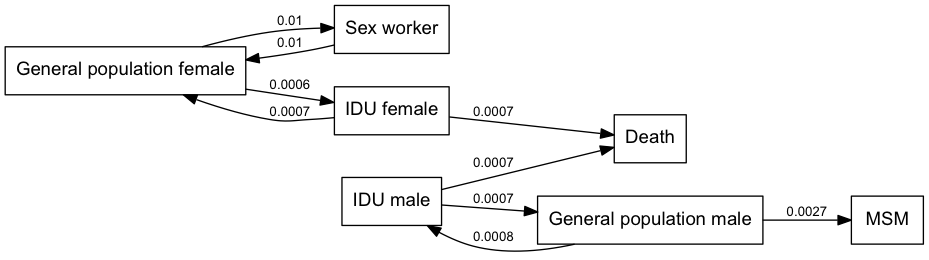

In [801]:
link_tps_to_chains()
visualize_chain(hiv_risk_groups_chain)
Image(filename='file.png')

#Diabetes disease

Now we can move on to building the diabetes related chains. Because we want treated diabetes to have a different interaction with TB than untreated diabetes, we need to have these as one chain.

In [802]:
# get TB chain
diabetes_disease_and_treatment = Chain.query.filter_by(name="Diabetes disease and treatment").first()

# create the chains we need
state_names = ["No diabetes", "Pre-diabetes", 
"Uncomplicated diabetes" , "Complicated diabetes (non-CVD)", 
 "Complicated diabetes (CVD)",  "Death" ]


for state_name in state_names:
    the_state = State(name=state_name,chain=diabetes_disease_and_treatment)
    save(the_state)
    
# print chains from database
State.query.filter_by(chain=diabetes_disease_and_treatment).all()

[No diabetes,
 Pre-diabetes,
 Uncomplicated diabetes,
 Complicated diabetes (non-CVD),
 Complicated diabetes (CVD),
 Death]

##Raw inputs

In [803]:

reference = Reference(name="From 149, page 8. Note 2.6 RR for obese and 1.15 for elderly")

# Transition from no DM to pre DM; High and low are WAG

risk_of_pre_dm_annual = Raw_input(
        name="Annual risk of developing pre-diabetes",
        slug="risk_of_pre_dm_annual",
        value=0.043,
        low=0.02,
        high=0.06,
        reference=reference
    )
    
save(risk_of_pre_dm_annual)
  
# Transition from pre DM to DM; same reference, High and low are WAG     

reference = Reference(name="WAG")

risk_of_uncomplicated_dm_annual = Raw_input(
    name="Annual risk of developing diabetes from pre-diabetes",
    slug="risk_of_uncomplicated_dm_annual",
    value=0.0135,
    low=0.01,
    high=0.03,
    reference=reference
)

save(risk_of_uncomplicated_dm_annual)

# Annual progression uncomplicated to complicated non-CVD, WAG

reference = Reference(name="WAG")

progression_of_diabetes_annual = Raw_input(
    name="Annual progression uncomplicated to complicated non-CVD",
    slug="progression_of_diabetes_annual",
    value=0.1,
    low=0.05,
    high=0.15,
    reference=reference
)

save(progression_of_diabetes_annual)

# Annual progression complicated non-CVD to complicated CVD, WAG

reference = Reference(name="WAG")

progression_of_diabetes_cvd_annual = Raw_input(
    name="Annual progression complicated non-CVD to CVD",
    slug="progression_of_diabetes_cvd_annual",
    value=0.1,
    low=0.05,
    high=0.15,
    reference=reference
)

save(progression_of_diabetes_cvd_annual)



Transition probabilities

In [804]:

# get TB resistance chain
dm_disease_chain = Chain.query.filter_by(name="DM disease").first()

# Get states

no_diabetes_state =  State.query.filter_by(name="No diabetes",chain=dm_disease_chain).first()
pre_diabetes_state =  State.query.filter_by(name="Pre-diabetes",chain=dm_disease_chain).first()
uncomplicated_diabetes_state =  State.query.filter_by(name="Uncomplicated diabetes",chain=dm_disease_chain).first()
complicated_diabetes_non_cvd_state =  State.query.filter_by(name="Complicated diabetes (non-CVD)",chain=dm_disease_chain).first()
complicated_diabetes_cvd_state =  State.query.filter_by(name="Complicated diabetes (CVD)",chain=dm_disease_chain).first()
death_state =  State.query.filter_by(name="Death",chain=dm_disease_chain).first()

risk_of_pre_dm_qt = convert_year_to_qt(risk_of_pre_dm_annual.value)
risk_of_uncomplicated_dm_qt = convert_year_to_qt(risk_of_uncomplicated_dm_annual.value)
progression_of_diabetes_qt = convert_year_to_qt(progression_of_diabetes_annual.value)
progression_of_diabetes_cvd_qt = convert_year_to_qt(progression_of_diabetes_cvd_annual.value)

# Development of pre-diabetes

save(Transition_probability(
    From_state=no_diabetes_state,
    To_state=pre_diabetes_state,
    Tp_base=risk_of_pre_dm_qt,
    Is_dynamic=False
))

# Development of diabetes

save(Transition_probability(
    From_state=pre_diabetes_state,
    To_state=uncomplicated_diabetes_state,
    Tp_base=risk_of_uncomplicated_dm_qt,
    Is_dynamic=False
))

# Progression to complicated diabetes

save(Transition_probability(
    From_state=uncomplicated_diabetes_state,
    To_state=complicated_diabetes_non_cvd_state,
    Tp_base=progression_of_diabetes_qt,
    Is_dynamic=False
))


# Progression from complicated to CVD complications

save(Transition_probability(
    From_state=complicated_diabetes_non_cvd_state,
    To_state=complicated_diabetes_cvd_state,
    Tp_base=progression_of_diabetes_cvd_qt,
    Is_dynamic=False
))


We can now visualize these transition probabilites.

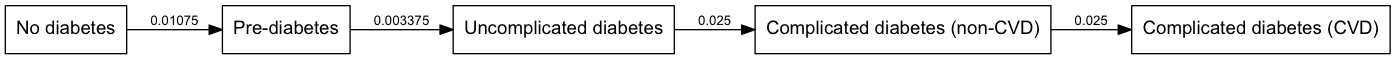

In [805]:
link_tps_to_chains()
visualize_chain(dm_disease_chain)
Image(filename='file.png')

# Diabtes treatment

In [806]:

# Transition from untreated uncomplicated to treated uncomplicated; WAG

treatment_uptake_uncomplicated_dm_annual = Raw_input(
   name="Annual treatment uptake, uncomplicated diabetes",
   slug="treatment_uptake_uncomplicated_dm_annual",
   value=0.1,
   low=0.05,
   high=0.15,
   reference=reference
)
       
save(treatment_uptake_uncomplicated_dm_annual)



# Annual progression of untreated non-CVD to CVD


#Annual progression from uncomplicated untreated DM to complicated, 
    